In [1]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [26]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input,LayerNormalization, 
                                        GlobalMaxPooling1D, Conv1D, MaxPooling1D, Concatenate)
from tensorflow.keras.optimizers import Adam

## 1. Load Dataset

In [2]:
dataset = load_dataset('uit-nlp/vietnamese_students_feedback')
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

In [3]:
#Chuyển dataset thành dataframe
train_df = dataset['train'].to_pandas()
print('Train:', train_df.shape)
val_df = dataset['validation'].to_pandas()
print('Val: ', val_df.shape)
test_df = dataset['test'].to_pandas()
print('Test: ', test_df.shape)

#Gộp các df lại thành 1 df tên sentiment_data
sentiment_data = pd.concat([train_df, val_df, test_df], ignore_index = True)

#Xáo trộn thứ tự các dòng dataframe tránh việc mô hình học theo thứ tự dữ liệu, dẫn đến hiện tượng overfitting(học thuộc)
sentiment_data = sentiment_data.sample(frac = 1).reset_index(drop = True)
print('Sentiment data:', sentiment_data.shape)

#Đổi tên cột
sentiment_data = sentiment_data.rename(columns={'sentence' : 'comment','sentiment' : 'label'})
sentiment_data.head()

Train: (11426, 3)
Val:  (1583, 3)
Test:  (3166, 3)
Sentiment data: (16175, 3)


,comment,label,topic
0,thầy giảng chưa sâu !,0,0
1,"giảng dạy nhiệt tình , vui vẻ .",2,0
2,"thầy nhiệt tình dạy giỏi , cung cấp tài liệu c...",2,0
3,"cấu trúc đề cương của thầy chưa rõ ràng , lý t...",0,1
4,"em thấy nên sử dụng slide tiếng việt , sinh vi...",0,1


## 2. Data preprocessing

### 2.1 Duplicated

In [4]:
# Đếm số hàng trùng lặp và xóa
print('Số dữ liệu bị lặp: ', sentiment_data['comment'].duplicated().sum())
sentiment_data = sentiment_data.drop_duplicates('comment')

# Kiểm tra lại sau khi xóa
print('Số dữ liệu bị lặp sau khi xóa: ', sentiment_data['comment'].duplicated().sum())

sentiment_data = sentiment_data.reset_index(drop = True)
sentiment_data.shape

Số dữ liệu bị lặp:  1
Số dữ liệu bị lặp sau khi xóa:  0


(16174, 3)

### 2.2 Missing

In [5]:
# Kiểm tra giá trị missing
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16174 entries, 0 to 16173
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  16174 non-null  object
 1   label    16174 non-null  int64 
 2   topic    16174 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 379.2+ KB


### 2.3 Over-sampling

In [6]:
def visualization_labels(sentiment_data):
    #Khảo sát
    label_counts = sentiment_data['label'].value_counts().sort_index()
    
    print('BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ:', sentiment_data.shape)
    print('CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:\n ', label_counts)
    
    #Trực quan hóa
    plt.figsize = (9,9)
    
    labels = ['Tiêu cực', 'Trung lập', 'Tích cực']
    mycolors = ['#009299', '#7ed957', '#00b980']
    plt.pie(label_counts, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = mycolors)
    plt.title('Tỉ lệ số nhãn trong đánh giá')

BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ: (16174, 3)
CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:
  label
0    7438
1     698
2    8038
Name: count, dtype: int64


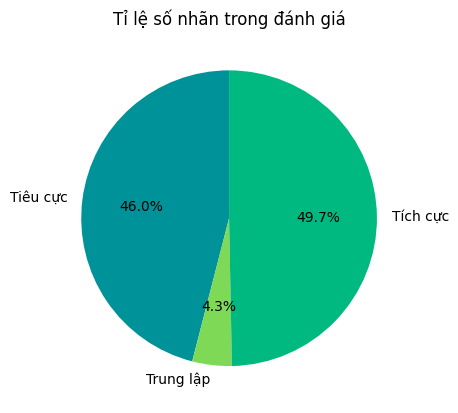

In [7]:
visualization_labels(sentiment_data)

In [8]:
from sklearn.utils import resample

train_comments = sentiment_data['comment'].values
# print(train_comments)

train_labels = sentiment_data['label'].values
# print(train_labels)

# Tìm chỉ số các câu trung lập(label=1)
neutral_indices = np.where(train_labels == 1)[0]

oversample_size = len(train_labels[train_labels ==0]) - len(neutral_indices)

oversampled_neutral_indices = resample(neutral_indices,
                                       replace = True,
                                       n_samples = oversample_size,
                                       random_state = 42)
oversampled_neutral_comments = train_comments[oversampled_neutral_indices]

train_comments_oversampled = np.concatenate([train_comments,oversampled_neutral_comments], axis = 0)
train_labels_oversampled = np.concatenate([train_labels, np.array([1]*oversample_size)], axis = 0)

In [15]:
sentiment_data_oversampled = pd.DataFrame({
    'comment' : train_comments_oversampled,
    'label' : train_labels_oversampled
})

sentiment_data = sentiment_data_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ: (22914, 2)
CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:
  label
0    7438
1    7438
2    8038
Name: count, dtype: int64


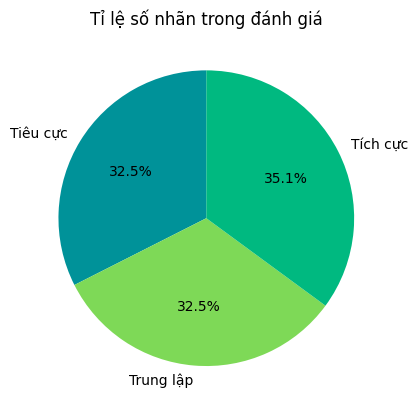

In [16]:
visualization_labels(sentiment_data)

### 2.4 Data normaliztion

In [17]:
import regex as re
import string
from underthesea import word_tokenize, text_normalize

#CHUẨN HÓA DỮ LIỆU
#Sử dụng hàm nhận diện icon 
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F" 
                u"\U0001F300-\U0001F5FF" 
                u"\U0001F680-\U0001F6FF" 
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0" 
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    
    text=text.lower()  #chuyển toàn bộ text về chữ thường 
    text=re.sub(emoji_pattern," ",text)    #loại bỏ icon
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)  #loại bỏ các ký chữ lặp trong từ(aaaaabbbb--> ab)


    #Đảm bảo khoảng trắng trước và sau giữa các dấu câu --> se , ti
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)

    #Xóa bớt các dấu câu lặp lại --> !!!!->!
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    #Loại bỏ các dấu câu hoặc khoảng trắng ở đâu và cuối câu
    text=text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    #Loại bỏ tất cả các dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))

    #Loại bỏ các khoảng trắng dư thừa trong câu
    text = re.sub(r"\s+", " ", text)

    #Tách từ 
    text = text_normalize(text)
    text = word_tokenize(text, format="text")

    return text

In [18]:
print('Câu gốc: ', sentiment_data['comment'][6])
print('Chuẩn hóa: ', clean_text(sentiment_data['comment'][6]))

Câu gốc:  giảng bài tập kết hợp lý thuyết .
Chuẩn hóa:  giảng bài_tập_kết_hợp lý_thuyết


In [19]:
sentiment_data['corpus'] = sentiment_data['comment'].map(lambda text: clean_text(text))                                                     
sentiment_data.head(20)

,comment,label,corpus
0,"giảng viên nhiệt tình , truyền đạt kiến thức d...",2,giảng_viên nhiệt_tình truyền_đạt kiến_thức dễ ...
1,thầy dạy hay nhưng mà dữ quá nên sinh viên hơi...,0,thầy dạy hay nhưng_mà dữ quá nên sinh_viên hơi sợ
2,giữ nguyên hình thức cũ !,1,giữ nguyên hình_thức cũ
3,giảng viên cho nhiều bài tập để sinh viên làm .,1,giảng_viên cho nhiều bài_tập để sinh_viên làm
4,thầy giảng lý thuyết sơ sài rồi kêu sinh viên ...,0,thầy giảng lý_thuyết sơ_sài rồi kêu sinh_viên ...
5,hy vọng học kỳ sau có thể học với cô .,2,hy_vọng học_kỳ sau có_thể học với cô
6,giảng bài tập kết hợp lý thuyết .,1,giảng bài_tập_kết_hợp lý_thuyết
7,"kiến thức , khả năng truyền đạt .",1,kiến_thức khả_năng truyền_đạt
8,không biết cô wzjwz327 là ai ?,1,không biết cô wzjwz327 là ai
9,"kiến thức nhiều , khó tiếp thu , phân loại chư...",0,kiến_thức nhiều khó tiếp_thu phân_loại chưa rõ


### 2.5 Visualization

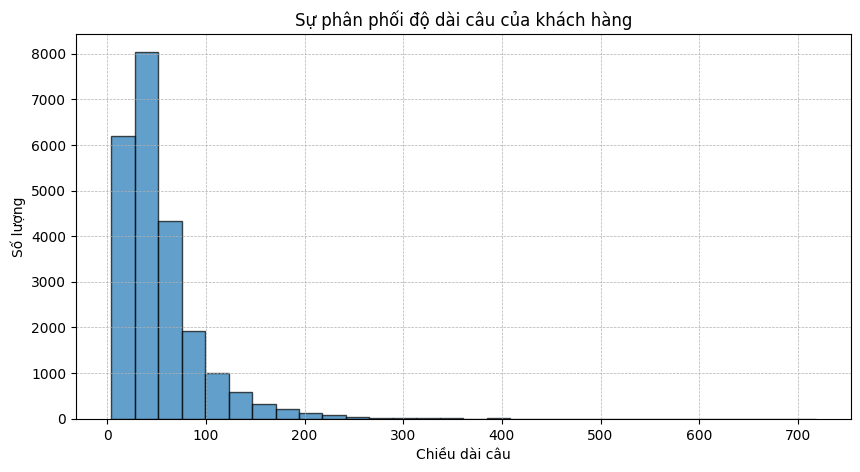

In [20]:
#Xem chiều dài của comment tập trung chủ yếu bao nhiêu 
lengths = sentiment_data['comment'].apply(len)

#Biểu đồ histogram
plt.figure(figsize=(10,5))
plt.hist(lengths, edgecolor='k', bins=30, alpha=0.7)#bin=30 chia khoảng giá trị thành 30 nhóm 
plt.title('Sự phân phối độ dài câu của khách hàng')
plt.xlabel('Chiều dài câu')
plt.ylabel('Số lượng')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

Số tất cả từ: 16001
Số từ xuất hiện nhiều nhất top 15: [('không có ạ', 31), ('không có ý_kiến', 29), ('em cảm_ơn', 25), ('không có ý_kiến gì', 24), ('em cám_ơn', 22), ('đã có làm đơn với phòng đào_tạo', 20), ('do học_kỳ này em không_thể đến lớp_học môn này nên em không_thể đưa ra ý_kiến gì thêm', 19), ('điều này tạo cho sinh_viên sự chủ_động trong học_tập', 19), ('dù phương_pháp học_tập này khá hiệu_quả nhưng vẫn có chút nào đó nghi_ngờ từ phần thuyết_trình của các bạn_liệu các kiến_thức đó có chuẩn_xác và cập_nhật chưa', 19), ('không có điều gì', 19), ('cảm_ơn', 19), ('không dám ý_kiến', 19), ('cảm_ơn thầy', 19), ('cho các nhóm tự nghiên_cứu và thuyết_trình', 19), ('cám ơn thầy', 19)]


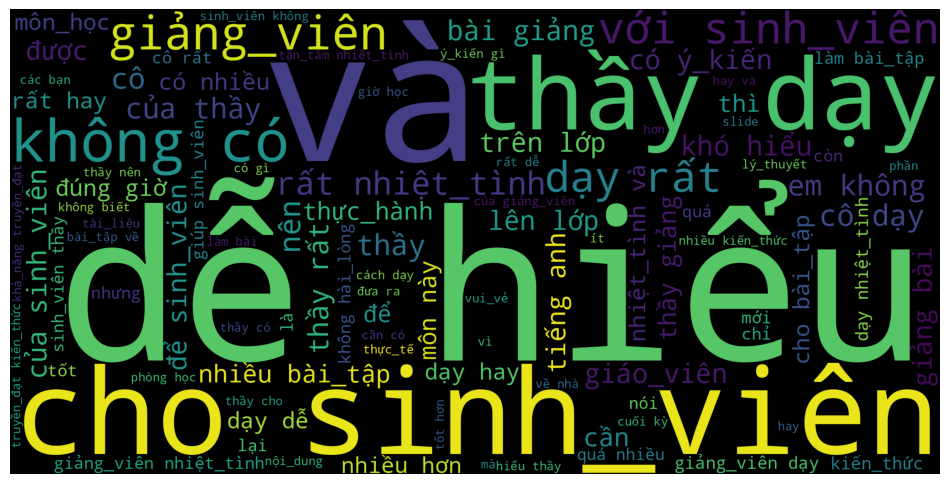

In [21]:
import nltk
import wordcloud

#XEM TRẠNG THÁI BAN ĐẦU CHƯA DỰ ĐOÁN CỦA BỘ DỮ LIỆU 

#Lọc bỏ các khoảng trắng chỉ lấy chữ
all_words= [token for token in sentiment_data['corpus'].tolist() if token and token!=' ']
 
corpus=' '.join(all_words)   #Nối lại thành chuỗi
all_words = nltk.FreqDist(all_words)  #Tính tần suất xuất hiện của từng từ trong danh sách 

print('Số tất cả từ: {}'.format(len(all_words)))
print('Số từ xuất hiện nhiều nhất top 15: {}'.format(all_words.most_common(15)))


plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)

plt.axis("off")  #tắt hiển thị các trục 
plt.imshow(word_cloud)


## 3. Training

### 3.1 Data preparation

In [22]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle

from sklearn.model_selection import train_test_split

input_pre = sentiment_data['corpus'].tolist()
label_with_accent = sentiment_data['label'].tolist()

label_tf = to_categorical(label_with_accent, num_classes = 3)
input_pre = [str(item) for item in input_pre] #Biến đổi nhãn (label) thành ma trận on-hot encoding.

#Phân tách dữ liệu văn bản đầu vào
tokenizer_data = Tokenizer(oov_token = '<00V>') # gán các từ chưa máy chưa học thì sẽ gán bằng mã '<00V>' để tránh lỗi khi xử lý 
tokenizer_data.fit_on_texts(input_pre)  # tách từ + đếm số lần xuất hiện taoh thành một từ điển 

#Chuyển đổi văn bản thành vector số
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)   #Biến đổi các văn bản trong input_pre (chuỗi) thành danh sách các chuỗi số,tương ứng từ được thay thế bằng chỉ số tương ứng trong từ điển
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=45)  # Làm cho tất cả các chuỗi trong tokenized_data_text có cùng độ dài (ở đây là 45), nếu <45 thì thêm 0, ngược thì thì cắt bớt

#Lưu tokenizer(word_index) vào file nhằm mục đích tái sử dụng
pickle.dump(tokenizer_data, open('tokenizer_data.pkl','wb'))

# Chuyển vec_data thành numpy
vec_data = np.array(vec_data)  
print("Input data shape:", vec_data.shape)

# Lấy size từ vựng
data_vocab_size = len(tokenizer_data.word_index) + 1
print("Data vocab size:", data_vocab_size)

# Chia dữ liệu training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
'''
    vec_data: là dữ liệu đầu vào sau khi đã sử lý với chiều dài là 45
    label_tf: là nhãn tương ứng với dữ liệu đầu vào đã được mã hóa ở dạng one-host encoding
    test_size=0.2 : lấy 20% cho tập validation và còn lại 80% cho tập training
    random_state=42: đảm bảo dữ liệu được lấy ngẫu nhiên 
'''
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
'''
    X_train: là dữ liệu đầu vào
    y_train: là nhãn tương ứng với dữ liệu đầu vào
    test_size=0.1 : lấy 10% cho tập test từ tập training
    random_state=42: đảm bảo dữ liệu được lấy ngẫu nhiên 
'''
#training: chiếm 78%
# validation: chiếm 20%
# test: 8%


print("Training sample:", len(X_train))
print("Validation sample:", len(X_val))
print("Test sample:", len(X_test))

Input data shape: (22914, 45)
Data vocab size: 2817
Training sample: 16497
Validation sample: 4583
Test sample: 1834


### 3.2 Model CNN +Bi-LSTM

In [28]:
def generate_model():
    dropout_threshold = 0.4 # dùng để xác định tỉ lệ dropout trong mô hình, có nghĩa là trong mỗi lần huấn luyện thì sẽ có 40% cái connect sẽ bị ngắt kết nối ngẫu nhiên 
    input_dim = data_vocab_size # số từ vựng 
    output_dim = 32 # mỗi từ trong từ điển sẽ được ánh xạ với một vector là 32 chiều 
    input_length = 45
    initializer = tf.keras.initializers.GlorotNormal() # để tạo 1 trọng số ban đầu không phải là theo một cách ngẫu nhiên mà có tính toán cụ thể

    # Tầng đầu vào 
    input_layer = Input(shape=(input_length,)) # định ngĩa lớp đầu tiên của mô hình với một chiều dài cố định 

    # Tầng embedding --> nhằm mục đích chuyển đổi các chỉ số nguyên(các từ) thành vector nhúng
    feature = Embedding(input_dim=input_dim, #số tất cả các từ vựng 
                        output_dim=output_dim, # mỗi từ được biểu diễn 1 vector nhúng 32 chiều 
                        input_length=input_length,#độ dài chuỗi đầu vào 
                        embeddings_initializer=initializer)(input_layer)#khởi tạo các giá trị trong bảng nhúng 

    # CNN feature 
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    '''
    --> Conv1D: tạo 1 lớp tích chập quét dữ liệu 1 chiều dọc 
    filters=32: có 32 bộ lọc 
    kernel_size=3: kích thước bộ lọc =3--> mỗi lần quét sẽ là 3 từ
    padding='same': đầu ra sẽ cùng kích thước đầu vào 
    activation='relu': tính toán dữ liệu đầu vào dựa theo hàm relu (>0 thì nhận ,<0 thì =0)
    '''
    cnn_feature = MaxPooling1D()(cnn_feature)#--> là giảm kích thước dữ liệu 
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)#-->giảm thiểu overfitting
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature) #chuẩn hóa các đặc trưng trong một lớp, giúp giảm thiểu các vấn đề về độ lệch chuẩn của các giá trị và giúp quá trình huấn luyện trở nên ổn định hơn.
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # BiLSTM feature 
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True,kernel_initializer=initializer), merge_mode='concat')(feature)
    ''' merge_mode='concat': nghĩa là nếu lstm có 32 chiều thì mô hình hình sẽ tạo ra 64 chiều,32 chiều trước, 32 chiều sau '''
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    # BiGRU feature 
    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True,kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Combine features
    combine_feature = Concatenate()([cnn_feature, bi_lstm_feature]) # kết nối 2 feature lại thành 1 feature mới 
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Tầng 
    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    # Định nghĩa mô hình
    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

In [27]:
model=generate_model()
adam=Adam(learning_rate=0.001)  # khởi tạo bộ tốc độ học với tốc độ 0.001
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 45)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 45, 32)            │          90,144 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 45, 32)            │           3,104 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 22, 32)            │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 22, 32)            │               0 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 45, 64)            │          16,640 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 22, 32)            │           3,104 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_2               │ (None, 22, 64)            │               0 │ bidirectional[0][0]        │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 11, 32)            │               0 │ conv1d_1[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 22, 64)            │          18,816 │ max_pooling1d_2[0][0]      │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 11, 32)            │              64 │ max_pooling1d_1[0][0]      │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_3               │ (None, 11, 64)            │               0 │ bidirectional_1[0][0]      │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 11, 32)            │               0 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 11, 64)            │             128 │ max_pooling1d_3[0][0]      │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 152,465 (595.57 KB)

 Trainable params: 152,465 (595.57 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.keras', monitor='val_loss')
'''lưu trạng thái tốt nhất của mô hình trong quá trình huấn luyện 
monitor='val_loss': dựa trên giá trị val_loss nhỏ nhất
--> khi val_loss giảm hơn so với epochs trước đó thì sẽ được lưu vào mô hình 
'''
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[callback_model])

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9484 - loss: 0.1723 - val_accuracy: 0.9271 - val_loss: 0.2256
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9532 - loss: 0.1540 - val_accuracy: 0.9337 - val_loss: 0.2218
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9526 - loss: 0.1576 - val_accuracy: 0.9404 - val_loss: 0.2112
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9532 - loss: 0.1539 - val_accuracy: 0.9389 - val_loss: 0.2201
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9570 - loss: 0.1403 - val_accuracy: 0.9413 - val_loss: 0.2059
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9592 - loss: 0.1355 - val_accuracy: 0.9380 - val_loss: 0.2034
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9598 - loss: 0.1317 - val_accuracy: 0.9356 - val_loss: 0.2206
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9625 - loss: 0.1238 - val_accu

In [38]:
from tensorflow.keras.models import load_model

model.load_weights("model_cnn_bilstm.h5")
model.evaluate(X_test,y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9423 - loss: 0.1913


[0.200882688164711, 0.9394765496253967]

### 4. Test

In [39]:
# Hàm tiền xử lý đầu vào
def preprocess_raw_input(raw_input, tokenizer):

    input_text_pre=clean_text(raw_input)
    print("Text:", input_text_pre)

    # Chuyển đổi văn bản thành vector số 
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=45)  # padding cho dữ liệu
    return vec_data

# Hàm dự đoán với mô hình
def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()  # Lấy chỉ số lớp có giá trị dự đoán cao nhất
    conf = float(output.max())  # Độ tin cậy của dự đoán (giá trị dự đoán cao nhất)
    label_dict = {'Tiêu cực': 0, 'Trung lập': 1, 'Tích cực': 2}
    labels = list(label_dict.keys())  # Lấy các nhãn
    return labels[int(result)], conf  # Trả về nhãn và độ tin cậy

# Hàm dự đoán cuối cùng
def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)  # Tiền xử lý đầu vào
    result, conf = inference_model(input_model, model)  # Dự đoán với mô hình
    return result, conf  # Trả về kết quả và độ tin cậy


In [41]:
my_model=generate_model()
my_model=load_model("model_cnn_bilstm.keras")

with open (r"tokenizer_data.pkl","rb") as input_file:
    my_tokenizer=pickle.load(input_file)
print(prediction("Thầy giảng hay lắm!!",my_tokenizer,my_model))

Text: thầy giảng hay lắm
('Tích cực', 0.9990247488021851)


In [42]:
while True:
    text = input("Nhập văn bản (hoặc gõ 'end' để kết thúc): ")
    if text.lower() == "end":
        break
    else:
        # Dự đoán và in kết quả
        prediction_result = prediction(text, my_tokenizer, my_model)
        print(str(prediction_result) + "\n")  # Đảm bảo kết quả là chuỗi trước khi nối

Nhập văn bản (hoặc gõ 'end' để kết thúc):  tôi buồn 


Text: tôi buồn
('Tiêu cực', 0.9421778321266174)



Nhập văn bản (hoặc gõ 'end' để kết thúc):  end


In [32]:
from tensorflow.keras.utils import plot_model
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.
